In [5]:
import pandas as pd
import dask
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.utils import shuffle
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
import spacy
spacy.load("en_core_web_sm")
from spacy.lang.en import English
#spacy.load('en')
parser = English()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing
<b>Line Parser</b> Parse each line in .webgateway file to entities

In [9]:
#   #given a line of a generic log entry of the format shown in line 7, return a dictionary of labeled informtion
def generic_line_parser(data, eof, file_name):
    # example data
    #logLine = '[09/Jan/2014:04:53:04 -0800] "Nico Rosberg" 172.16.2.101 77.75.107.241 1500 200 TCP_HIT "GET http://www.divernet.com/ HTTP/1.1" "Internet Services" "low risk " "text/html; charset=utf-8" 470 396 "Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)" "http://www.google.com/url?sa=t&rct=j&q=&esrc=s&frm=1&source=web&cd=1&sqi=2&ved=0CCoQFjAA&url=http%3A%2F%2Fwww.divernet.com%2F&ei=opvOUpyXFrSA2QXnv4DwDg&usg=AFQjCNHeSe4ebK0u69M-TBEGNkTZy-C-Nw&bvm=bv.59026428,d.b2I" "-" "0" "" "-" '

    #logPattern = '\[(?P<dateTime>.*?) (?P<timezone>.*?)\] \"(?P<userName>.*?)\" (?P<sourceIP>.*?) (?P<destinationIP>.*?) (?P<unknownValue>.*?) (?P<statusCode>.*?) (?P<cacheResult>.*?) \"(?P<httpMethod>.*?) (?P<urlRequested>.*?) HTTP/(?P<httpVersion>.*?)\" \"(?P<domainClassification>.*?)\" \"(?P<riskClassification>.*?)\" \"(?P<mimeType>.*?)\" (?P<bytesSent>.*?) (?P<bytesReceived>.*?) \"(?P<userAgentString>.*?)\" \"(?P<webReferrerString>.*?)\" \"(?P<urlMeta1>.*?)\" \"(?P<urlMeta2>.*?)\" \"(?P<urlMeta3>.*?)\" \"(?P<urlMeta4>.*?)\"'
    def to_epoch(dt):
        epoch = pd.to_datetime('1970-01-01')
        return (dt - epoch).total_seconds()
    if not eof:
        data = ' '.join(data.split())
        logPattern = '\[(?P<dateTime>.*?) (?P<timezone>.*?)\] \"(?P<userName>.*?)\" (?P<sourceIP>.*?) (?P<destinationIP>.*?) (?P<unknownValue>.*?) (?P<statusCode>.*?) (?P<cacheResult>.*?) \"(?P<httpMethod>.*?) (?P<urlRequested>.*?) HTTP\/(?P<httpVersion>.*?)\" \"(?P<domainClassification>.*?)\" \"(?P<riskClassification>.*?)\" \"(?P<mimeType>.*?)\" (?P<bytesSent>.*?) (?P<bytesReceived>.*?) \"(?P<userAgentString>.*?)\" \"(?P<webReferrerString>.*?)\" \"(?P<urlMeta1>.*?)\" \"(?P<urlMeta2>.*?)\" \"(?P<urlMeta3>.*?)\" \"(?P<urlMeta4>.*?)\"'
        matched = re.match(logPattern, data)
        matched_dict = matched.groupdict()


        #   #get the timestamp as a string, reformated to feed into pd.to_datetime
        #   #get the epoch time using the to_epoch function

        valPartitioned = data.split(" ")
        dt_string = valPartitioned[0].replace("[", "").replace(":"," ", 1)
        timeZone = valPartitioned[1].replace("]","")
        #timeZone = timeZone.replace("0","")
        dt_string = dt_string + " " + timeZone
        dt_obj = pd.to_datetime(dt_string)
        dt_obj = dt_obj.replace(tzinfo=None)
        convertedTime = to_epoch(dt_obj)
        #now appended the dictionary with the dt_obj object and dt_string and
        #the concatinated URL meta data
        matched_dict['convertedTime'] = convertedTime
        matched_dict['timeString'] = dt_string
        matched_dict['urlMeta'] =  matched_dict['urlMeta1'] + " " + matched_dict['urlMeta2'] + " " + matched_dict['urlMeta3'] + " " + matched_dict['urlMeta4']
        return(matched_dict)
    else:
        return None

# Handle Big Data
<b>Chunking</b> read lines from the file as data chunks, chunks of 100MB is used

In [7]:
def read_lines_from_file_as_data_chunks(file_name, chunk_size, callback, return_whole_chunk=False):
    """
    read file line by line regardless of its size
    :param file_name: absolute path of file to read
    :param chunk_size: size of data to be read at at time
    :param callback: callback method, prototype ----> def callback(data, eof, file_name)
    :return:
    """
    results = list()
    def read_in_chunks(file_obj, chunk_size=5000):
        """
        https://stackoverflow.com/a/519653/5130720
        Lazy function to read a file 
        Default chunk size: 5000.
        """
        while True:
            data = file_obj.read(chunk_size)
            if not data:
                break
            yield data

    fp = open(file_name, encoding='utf8')
    data_left_over = None

    # loop through characters
    for chunk in read_in_chunks(fp, chunk_size= chunk_size):


        # if uncompleted data exists
        if data_left_over:
            # print('\n left over found')
            current_chunk = data_left_over + chunk
        else:
            current_chunk = chunk

        # split chunk by new line
        lines = current_chunk.splitlines()

        # check if line is complete
        if current_chunk.endswith('\n'):
            data_left_over = None

        else:
            data_left_over = lines.pop()

        if return_whole_chunk:
            result = callback(data=lines, eof=False, file_name=file_name)
            results.append(result)

        else:

            for line in lines:
                result = callback(data=line, eof=False, file_name=file_name)
                results.append(result)
                pass

    if data_left_over:

        current_chunk = data_left_over
        if current_chunk is not None:

            lines = current_chunk.splitlines()

            if return_whole_chunk:
                result = callback(data=lines, eof=False, file_name=file_name)
                results.append(result)
            else :
                for line in lines:
                    result = callback(data=line, eof=False, file_name=file_name)
                    results.append(result)
                    pass

    callback(data=None, eof=True, file_name=file_name)
    return results

In [69]:
file_name = './Downloads/sanitized_bluecoat_from_syrian_dump.webgateway/BlueCoat_Large.webgateway'
CHUNK_SIZE = 100000000
results = read_lines_from_file_as_data_chunks(file_name, chunk_size=CHUNK_SIZE, callback=generic_line_parser)

# Final clean Entities
Entities are fetched from each log line form <b>.webgateway</b> file. The final result is list of dictionary of all entities

In [5]:
 results

[{'dateTime': '02/Aug/2011:22:00:00',
  'timezone': '-0700',
  'userName': 'user_1',
  'sourceIP': '0.0.0.0',
  'destinationIP': '0.0.0.0',
  'unknownValue': '9080',
  'statusCode': '200',
  'cacheResult': 'TCP_HIT',
  'httpMethod': 'GET',
  'urlRequested': 'http://games.maktoob.com/smart/gamesCH1/gimages/smart1040.jpeg',
  'httpVersion': '1.0',
  'domainClassification': 'unknown',
  'riskClassification': 'low risk',
  'mimeType': 'image/jpeg',
  'bytesSent': '2370',
  'bytesReceived': '409',
  'userAgentString': 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/534.10 (KHTML, like Gecko) Chrome/8.0.552.237 Safari/534.10',
  'webReferrerString': 'i1.makcdn.com',
  'urlMeta1': '-',
  'urlMeta2': '0',
  'urlMeta3': '',
  'urlMeta4': '-',
  'convertedTime': 1312322400.0,
  'timeString': '02/Aug/2011 22:00:00 -0700',
  'urlMeta': '- 0  -'},
 {'dateTime': '02/Aug/2011:22:00:00',
  'timezone': '-0700',
  'userName': 'user_2',
  'sourceIP': '0.0.0.0',
  'destinationIP': '0.0.0.0',


# Creating DataFrame from Entities Dictionary list

In [6]:
benign_df = pd.DataFrame(results)

# Sampling 
As data is very huge and due to constraint of time selecting <b>100 records</b> from <b> 500 Users</b>

In [9]:
selected_users_benign = benign_df.groupby('userName').head(100)

In [16]:
selected_users_benign.userName.value_counts()

user_1      100
user_330    100
user_343    100
user_342    100
user_341    100
           ... 
user_162    100
user_161    100
user_160    100
user_159    100
user_0      100
Name: userName, Length: 500, dtype: int64

# Distribution
Analysing the distribution of <b>cache Results</b>

In [17]:
selected_users_benign.cacheResult.value_counts()

TCP_NC_MISS           26468
TCP_HIT               12958
TCP_MISS               6561
TCP_ERR_MISS           2977
TCP_DENIED              395
TCP_CLIENT_REFRESH      264
TCP_NC_MISS_RST         153
TCP_TUNNELED             85
TCP_REFRESH_MISS         76
TCP_PARTIAL_MISS         61
TCP_MISS_RST              1
TCP_AUTH_HIT              1
Name: cacheResult, dtype: int64

# Missing Values
Checking for missing values

In [18]:
selected_users_benign.isna().sum()

dateTime                0
timezone                0
userName                0
sourceIP                0
destinationIP           0
unknownValue            0
statusCode              0
cacheResult             0
httpMethod              0
urlRequested            0
httpVersion             0
domainClassification    0
riskClassification      0
mimeType                0
bytesSent               0
bytesReceived           0
userAgentString         0
webReferrerString       0
urlMeta1                0
urlMeta2                0
urlMeta3                0
urlMeta4                0
convertedTime           0
timeString              0
urlMeta                 0
dtype: int64

# Distribution of cache results on random users v Overall
Distribution looks quite similar among selected users vs overall


<AxesSubplot: >

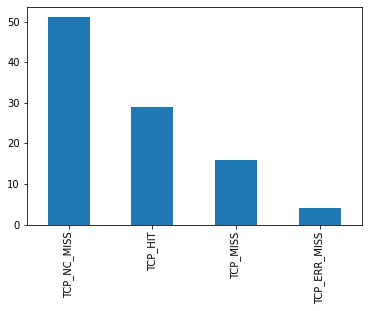

In [19]:
selected_users_benign[selected_users_benign.userName=='user_1']['cacheResult'].value_counts().plot(kind='bar')

<AxesSubplot: >

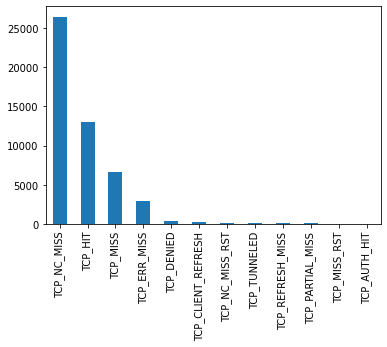

In [14]:
selected_users_benign['cacheResult'].value_counts().plot(kind='bar')

# Text Preprocessing

In [21]:
benign_train[0]

'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/534.10 (KHTML, like Gecko) Chrome/8.0.552.237 Safari/534.10'

In [14]:
# tokenizing the raw text
def tokenizeText(sample):
    clean_sample = sample.replace("/", "").replace(";","").replace("(","").replace(")", "").replace("-","").replace(",", "")
    tokens = parser(clean_sample).to_bytes()
    return list(tokens)

In [9]:
tokenizeText(benign_train[0])

[137,
 164,
 116,
 101,
 120,
 116,
 217,
 106,
 77,
 111,
 122,
 105,
 108,
 108,
 97,
 53,
 46,
 48,
 32,
 87,
 105,
 110,
 100,
 111,
 119,
 115,
 32,
 85,
 32,
 87,
 105,
 110,
 100,
 111,
 119,
 115,
 32,
 78,
 84,
 32,
 53,
 46,
 49,
 32,
 101,
 110,
 85,
 83,
 32,
 65,
 112,
 112,
 108,
 101,
 87,
 101,
 98,
 75,
 105,
 116,
 53,
 51,
 52,
 46,
 49,
 48,
 32,
 75,
 72,
 84,
 77,
 76,
 32,
 108,
 105,
 107,
 101,
 32,
 71,
 101,
 99,
 107,
 111,
 32,
 67,
 104,
 114,
 111,
 109,
 101,
 56,
 46,
 48,
 46,
 53,
 53,
 50,
 46,
 50,
 51,
 55,
 32,
 83,
 97,
 102,
 97,
 114,
 105,
 53,
 51,
 52,
 46,
 49,
 48,
 170,
 97,
 114,
 114,
 97,
 121,
 95,
 104,
 101,
 97,
 100,
 159,
 71,
 81,
 65,
 67,
 75,
 79,
 76,
 77,
 78,
 205,
 1,
 196,
 205,
 1,
 198,
 73,
 205,
 1,
 197,
 74,
 80,
 170,
 97,
 114,
 114,
 97,
 121,
 95,
 98,
 111,
 100,
 121,
 133,
 196,
 2,
 110,
 100,
 195,
 196,
 4,
 116,
 121,
 112,
 101,
 163,
 60,
 117,
 56,
 196,
 4,
 107,
 105,
 110,
 100,
 196,
 0,
 196,
 5,

# Embeddings
Using TF-IDF embeddings

In [19]:
vectorizer = TfidfVectorizer(tokenizer=tokenizeText)

In [20]:
features = vectorizer.fit_transform(benign_train).toarray()
features.shape

C:\Users\Gaurav\anaconda3\envs\gaurav_conda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(35000, 256)

In [21]:
benign_train.shape

(35000,)

In [ ]:
selected_users_benign.to_csv('selected_users_benign.xlsx')

In [3]:
benign_data = pd.read_csv('selected_users_benign.xlsx')

# Train and Test Split

In [4]:
from sklearn.model_selection import train_test_split
benign_train, benign_test = train_test_split(benign_data['userAgentString'], test_size=0.3)

In [5]:
benign_train.shape

(35000,)

In [6]:
benign_train[0]

'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/534.10 (KHTML, like Gecko) Chrome/8.0.552.237 Safari/534.10'

In [10]:
tokenizeText(benign_train[0])

[137,
 164,
 116,
 101,
 120,
 116,
 217,
 106,
 77,
 111,
 122,
 105,
 108,
 108,
 97,
 53,
 46,
 48,
 32,
 87,
 105,
 110,
 100,
 111,
 119,
 115,
 32,
 85,
 32,
 87,
 105,
 110,
 100,
 111,
 119,
 115,
 32,
 78,
 84,
 32,
 53,
 46,
 49,
 32,
 101,
 110,
 85,
 83,
 32,
 65,
 112,
 112,
 108,
 101,
 87,
 101,
 98,
 75,
 105,
 116,
 53,
 51,
 52,
 46,
 49,
 48,
 32,
 75,
 72,
 84,
 77,
 76,
 32,
 108,
 105,
 107,
 101,
 32,
 71,
 101,
 99,
 107,
 111,
 32,
 67,
 104,
 114,
 111,
 109,
 101,
 56,
 46,
 48,
 46,
 53,
 53,
 50,
 46,
 50,
 51,
 55,
 32,
 83,
 97,
 102,
 97,
 114,
 105,
 53,
 51,
 52,
 46,
 49,
 48,
 170,
 97,
 114,
 114,
 97,
 121,
 95,
 104,
 101,
 97,
 100,
 159,
 71,
 81,
 65,
 67,
 75,
 79,
 76,
 77,
 78,
 205,
 1,
 196,
 205,
 1,
 198,
 73,
 205,
 1,
 197,
 74,
 80,
 170,
 97,
 114,
 114,
 97,
 121,
 95,
 98,
 111,
 100,
 121,
 133,
 196,
 2,
 110,
 100,
 195,
 196,
 4,
 116,
 121,
 112,
 101,
 163,
 60,
 117,
 56,
 196,
 4,
 107,
 105,
 110,
 100,
 196,
 0,
 196,
 5,

In [11]:
vectorizer = TfidfVectorizer(tokenizer=tokenizeText)

In [12]:
features = vectorizer.fit_transform(benign_train).toarray()
features.shape

C:\Users\Gaurav\anaconda3\envs\gaurav_conda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(35000, 256)

# Pipeline and Training
Creating pipeline for TF-IDF vectorizer with One Class SVM classifier, Treting this dataset as Unstructured and to find anomalies one class SVM can etablish a decision boundary i.e a hyperplane measuring distance from datapoints 

In [16]:
clf1 = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

pipe_clf_1 = Pipeline([('vectorizer', vectorizer), ('clf', clf1)])

In [17]:
pipe_clf_1.fit(benign_train)

C:\Users\Gaurav\anaconda3\envs\gaurav_conda\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function tokenizeText at 0x000001C6430A4940>)),
                ('clf', OneClassSVM(gamma=0.1, nu=0.1))])

In [18]:
joblib.dump(pipe_clf_1, "benign_model.sav")

['benign_model.sav']

In [19]:
#Saving the model
model = joblib.load('benign_model.sav')

# Predictions
In <b> One Class SVM </b> score of <b>1</b> means <b>normal</b> and score of <b>-1</b> refers to <b>anomaly</b>

In [20]:
# prediction on training set
predictions = model.predict(benign_train)

In [21]:
predictions

array([-1,  1,  1, ...,  1,  1,  1], dtype=int64)

In [22]:
predictions==-1

array([ True, False, False, ..., False, False, False])

In [23]:
import numpy as np
np.where(predictions==1)

(array([    1,     2,     3, ..., 34997, 34998, 34999], dtype=int64),)

In [32]:
#Predictions on test set
predictions_test = model.predict(benign_test)

In [48]:
predictions_test2 = pipe_clf.predict(benign_test)

In [49]:
predictions_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [50]:
type(benign_test)

pandas.core.series.Series

In [51]:
benign_test_df = benign_test.to_frame()

In [52]:
benign_test_df['predictions'] = predictions_test.tolist()

# Labelling
Labeling the train and test set based on the predictions, <b>-1</b> labeled as <b>not benign</b> and <b>+1</b> labeled as <b>benign</b>

In [53]:
benign_test_df['label'] = benign_test_df['predictions'].map({1: "benign", -1: "not benign"})

In [54]:
benign_test_df

,userAgentString,predictions,label
32366,Mozilla/5.0 (Windows; U; Windows NT 5.1; ar; r...,1,benign
22723,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign
21045,Shockwave Flash,1,benign
20314,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign
8723,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6...,1,benign
...,...,...,...
13364,Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_3_1 li...,1,benign
12919,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,1,benign
14524,Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...,1,benign
29399,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign


# Category distribution
<b> Benign and Not Benign <b> distribution

In [55]:
benign_test_df.label.value_counts()

benign        14196
not benign      804
Name: label, dtype: int64

<AxesSubplot: >

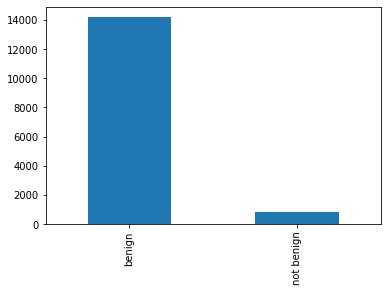

In [130]:
# for test set
benign_test_df.label.value_counts().plot(kind='bar')

In [56]:
benign_train_df = benign_train.to_frame()

In [57]:
benign_train_df

,userAgentString
39005,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...
19368,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...
18799,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...
41229,Opera/9.80 (Windows NT 6.0; U; en) Presto/2.9....
45406,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...
...,...
49334,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...
10080,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...
35943,Mozilla/5.0 (Windows; U; Windows NT 6.1; ar; r...
22482,Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US...


In [58]:
benign_train_df["predictions"] = predictions.tolist()

In [59]:
benign_train_df['label'] = benign_train_df["predictions"].map({1: "benign", -1:"not benign"})

In [60]:
benign_train_df

,userAgentString,predictions,label
39005,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
19368,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign
18799,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign
41229,Opera/9.80 (Windows NT 6.0; U; en) Presto/2.9....,1,benign
45406,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign
...,...,...,...
49334,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign
10080,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,1,benign
35943,Mozilla/5.0 (Windows; U; Windows NT 6.1; ar; r...,1,benign
22482,Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US...,1,benign


In [61]:
benign_train_df.label.value_counts()

benign        33244
not benign     1756
Name: label, dtype: int64

<AxesSubplot: >

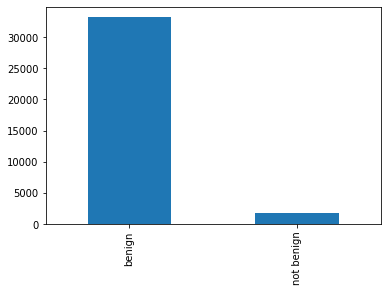

In [62]:
# for train set
benign_train_df.label.value_counts().plot(kind="bar")

In [63]:
benign_train_df.index

Int64Index([39005, 19368, 18799, 41229, 45406, 26976, 15264, 24527, 15053,
            36872,
            ...
            19618, 15193, 10209, 25094, 26698, 49334, 10080, 35943, 22482,
            34760],
           dtype='int64', length=35000)

# Decision Function
Decision function basically captures distances of each data points from the hyperplane establish during training one class SVM. Positive distances belongs to one class and negative distances to anomaly

In [64]:
pipe_clf_1.decision_function(benign_test)

array([ 4.65705738,  0.68924826, 37.93986127, ...,  9.13162376,
        3.8662652 ,  0.68924826])

In [71]:
benign_train_df[benign_train_df['label']=="not benign"]

,userAgentString,predictions,label
39005,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
21213,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
23505,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
31044,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
24882,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
...,...,...,...
29032,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
17577,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-1,not benign
7344,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-1,not benign
19725,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-1,not benign


In [72]:
benign_test_df[benign_test_df['label']=="not benign"]

,userAgentString,predictions,label
44438,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
39790,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
24403,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
35777,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
2599,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
...,...,...,...
48601,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
41952,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
2902,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,-1,not benign
8762,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,-1,not benign


In [74]:
final_df = pd.concat([benign_train_df, benign_test_df])

In [75]:
final_df

,userAgentString,predictions,label
39005,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign
19368,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign
18799,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign
41229,Opera/9.80 (Windows NT 6.0; U; en) Presto/2.9....,1,benign
45406,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign
...,...,...,...
13364,Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_3_1 li...,1,benign
12919,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,1,benign
14524,Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...,1,benign
29399,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign


In [76]:
final_df.label.value_counts()

benign        47440
not benign     2560
Name: label, dtype: int64

In [77]:
def clean_user_agent_string(sample):
    clean_sample = sample.replace("/", "").replace(";","").replace("(","").replace(")", "").replace("-","").replace(",", "")
    return clean_sample
    

In [78]:
final_df["clean_user_agent"] = final_df["userAgentString"].apply(clean_user_agent_string)

In [79]:
final_df.head()

,userAgentString,predictions,label,clean_user_agent
39005,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-1,not benign,Mozilla4.0 compatible MSIE 8.0 Windows NT 5.1 ...
19368,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 6.0 Windows NT 5.1 SV1
18799,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 6.0 Windows NT 5.1 ...
41229,Opera/9.80 (Windows NT 6.0; U; en) Presto/2.9....,1,benign,Opera9.80 Windows NT 6.0 U en Presto2.9.168 Ve...
45406,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 8.0 Windows NT 6.1 ...


# Word Clouds

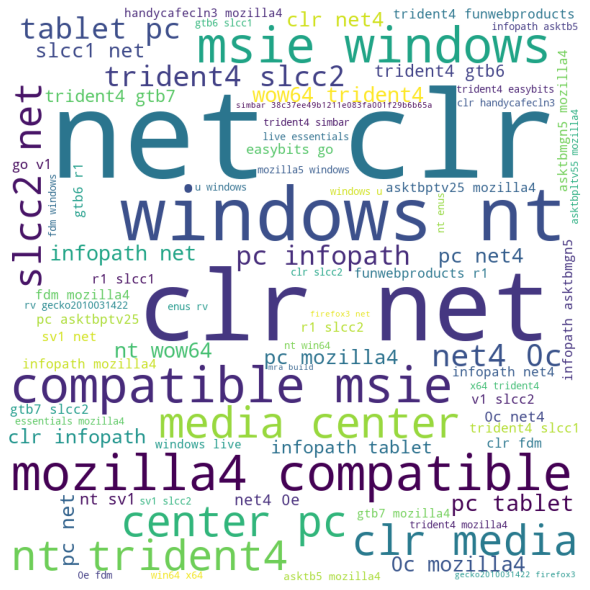

In [83]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
not_benign_df = final_df[final_df['label']=='not benign']
comment_words_not_benign = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in not_benign_df['clean_user_agent']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words_not_benign += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words_not_benign)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

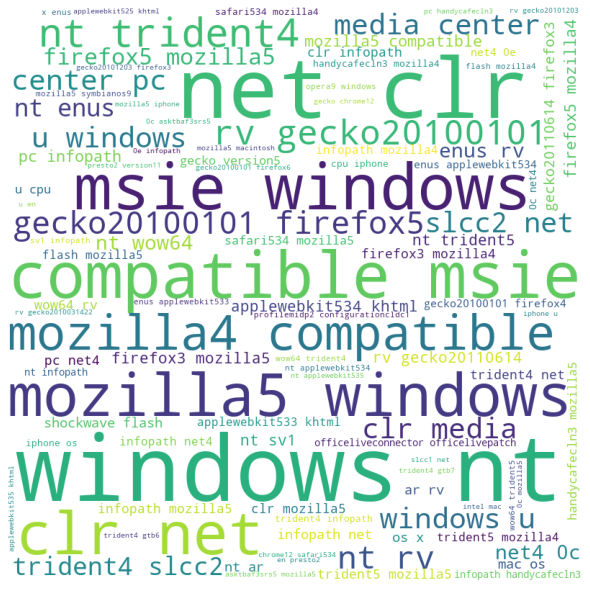

In [84]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
not_benign_df = final_df[final_df['label']=='benign']
comment_words_benign = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in not_benign_df['clean_user_agent']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words_benign += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words_benign)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [85]:
not_benign_df

,userAgentString,predictions,label,clean_user_agent
19368,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 6.0 Windows NT 5.1 SV1
18799,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 6.0 Windows NT 5.1 ...
41229,Opera/9.80 (Windows NT 6.0; U; en) Presto/2.9....,1,benign,Opera9.80 Windows NT 6.0 U en Presto2.9.168 Ve...
45406,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 8.0 Windows NT 6.1 ...
26976,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 8.0 Windows NT 6.1 ...
...,...,...,...,...
13364,Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_3_1 li...,1,benign,Mozilla5.0 iPhone U CPU iPhone OS 4_3_1 like M...
12919,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 7.0 Windows NT 5.1 ...
14524,Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...,1,benign,Mozilla5.0 Windows NT 6.1 rv:2.0.1 Gecko201001...
29399,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1,benign,Mozilla4.0 compatible MSIE 8.0 Windows NT 5.1 ...


# Evaluating terms responsible for anomaly
Extracting the terms(words) which belongs to not benign data points but not present in benign data points. Technique used is <b>SET DIFFERENCE</b>

In [107]:
def getUniqueWords(allWords) :
    uniqueWords = [] 
    for i in allWords:
        if not i in uniqueWords:
            uniqueWords.append(i)
    return uniqueWords


In [105]:
benign_lst = comment_words_benign.split(" ")

In [108]:
benign_unique = getUniqueWords(benign_lst)

In [109]:
benign_unique

['mozilla4.0',
 'compatible',
 'msie',
 '6.0',
 'windows',
 'nt',
 '5.1',
 'sv1',
 'yie8',
 'opera9.80',
 'u',
 'en',
 'presto2.9.168',
 'version11.50',
 '8.0',
 '6.1',
 'trident4.0',
 'slcc2',
 '.net',
 'clr',
 '2.0.50727',
 '3.5.30729',
 '3.0.30729',
 'media',
 'center',
 'pc',
 'fdm',
 '.net4.0c',
 '.net4.0e',
 'handycafecln3.3.21',
 'mozilla5.0',
 'linux',
 'android',
 '2.2',
 'arae',
 'gtp1000',
 'buildfroyo',
 'applewebkit533.1',
 'khtml',
 'like',
 'gecko',
 'version4.0',
 'mobile',
 'safari533.1',
 'rv:5.0.1',
 'gecko20100101',
 'firefox5.0.1',
 'infopath.2',
 'asktbstc5.11.3.15590',
 'rv:2.0',
 'firefox4.0',
 'funwebproducts',
 'enus',
 'rv:1.9.0.19',
 'gecko2010031422',
 'firefox3.0.19',
 'rv:1.9.2.18',
 'gecko20110614',
 'asktbstt3.12.2.16749',
 'btrs86019',
 'firefox3.6.18',
 '7.0',
 '3.0.4506.2152',
 '3.0.04506.30',
 'xp',
 'java1.6.0_24',
 'rv:6.0',
 'firefox6.0',
 'applewebkit534.24',
 'chrome11.0.696.16',
 'safari534.24',
 'btrs26049',
 'rv:5.0',
 'firefox5.0',
 'ar',
 

In [110]:
not_benign_lst = comment_words_not_benign.split(" ")

In [111]:
not_benign_unique = getUniqueWords(not_benign_lst)

In [112]:
not_benign_unique

['mozilla4.0',
 'compatible',
 'msie',
 '8.0',
 'windows',
 'nt',
 '5.1',
 'trident4.0',
 '.net',
 'clr',
 '1.1.4322',
 '2.0.50727',
 '3.0.4506.2152',
 '3.5.30729',
 'fdm',
 '6.1',
 'wow64',
 'gtb7.1',
 'slcc2',
 '3.0.30729',
 'media',
 'center',
 'pc',
 '6.0',
 'infopath.2',
 'gtb6.6',
 'tablet',
 '2.0',
 '.net4.0c',
 'infopath.1',
 '4.0.20506',
 'mra',
 '5.8',
 'build',
 '4157',
 'sv1',
 '3.0.04506.648',
 '3.5.21022',
 'bri2',
 'gtb6',
 'r1',
 '1.6',
 'slcc1',
 '3.0.30618',
 '7.0',
 'trident5.0',
 '.net4.0e',
 'boie9enusmsnip',
 'live',
 'essentials',
 '15.4.3538.0513',
 'searchtoolbar',
 '1.2',
 'btrs5384',
 'asktbhip5.12.2.16749',
 'handycafecln3.3.21',
 '5.0',
 'infopath.3',
 'simbar={239b50d2b86b11e08fc70025228fc035}',
 'creative',
 'autoupdate',
 'v1.40.01',
 'asktbptv25.9.1.14019',
 'easybits',
 'go',
 'v1.0',
 'hpntdf',
 'ant.com',
 'toolbar',
 'asktbaf3srs5.12.2.16752',
 'gtb6.3',
 'asktbff5.8.0.12304',
 'matm',
 'simbar={38c37ee49b1211e083fa001f29b6b65a}',
 'asktbpltv55.12.2

In [118]:
#Set difference of benign set from not benign set
anomaly_terms = set(not_benign_unique).difference(set(benign_unique))

# Anomaly Terms
Terms suspected to be held responsible for causing anomaly in user agents

In [119]:
anomaly_terms

{'#46ubuntu',
 '03789',
 '03797',
 '1.0.0',
 '1.1.1',
 '1.2.1',
 '11.04',
 '15.4.3502.0922',
 '15.4.3538.0513',
 '15:05:41',
 '2.1.6',
 '2.6.3810generic',
 '2011]>',
 '28',
 '301',
 '3773',
 '3797',
 '4.0.8',
 '4.5.2',
 '4.5.28ubuntu4',
 '4.7',
 '61b14fbf60',
 '<linux.32',
 '[distribution:',
 'asktbblpv55.9.1.14019',
 'asktbbt55.11.3.15590',
 'asktbclm5.11.3.15590',
 'asktbcwn5.8.0.12304',
 'asktbcwn5.9.1.14019',
 'asktbff5.8.0.12304',
 'asktbfxtv55.8.0.12304',
 'asktbggsv55.11.3.15590',
 'asktbijbme5.11.3.15590',
 'asktbmgn5.11.3.15590',
 'asktbmov5.9.1.14019',
 'asktbmp3r75.12.2.16749',
 'asktbnro25.11.3.15590',
 'asktbstt5.12.2.16749',
 'asktbwcl25.12.2.16749',
 'boie9enusmsnip',
 'btrs28191',
 'cpntdf',
 'ct2102473_4.5.188.7',
 'essentials',
 'gcc',
 'gtb5',
 'jun',
 'kernel:',
 'msnpstack',
 'my',
 'none',
 'simbar={239b50d2b86b11e08fc70025228fc035}',
 'simbar={32ad7ab0ac8511e081000019db695762}',
 'simbar={38c37ee49b1211e083fa001f29b6b65a}',
 'simbar={73b1df182fbb4848aee0478c3f107

In [121]:
final_df = final_df[['label', 'predictions', 'clean_user_agent']]

In [122]:
final_df

,label,predictions,clean_user_agent
39005,not benign,-1,Mozilla4.0 compatible MSIE 8.0 Windows NT 5.1 ...
19368,benign,1,Mozilla4.0 compatible MSIE 6.0 Windows NT 5.1 SV1
18799,benign,1,Mozilla4.0 compatible MSIE 6.0 Windows NT 5.1 ...
41229,benign,1,Opera9.80 Windows NT 6.0 U en Presto2.9.168 Ve...
45406,benign,1,Mozilla4.0 compatible MSIE 8.0 Windows NT 6.1 ...
...,...,...,...
13364,benign,1,Mozilla5.0 iPhone U CPU iPhone OS 4_3_1 like M...
12919,benign,1,Mozilla4.0 compatible MSIE 7.0 Windows NT 5.1 ...
14524,benign,1,Mozilla5.0 Windows NT 6.1 rv:2.0.1 Gecko201001...
29399,benign,1,Mozilla4.0 compatible MSIE 8.0 Windows NT 5.1 ...


# Meging back to Original Dataframe

In [123]:
results_df = pd.concat([benign_data, final_df], axis=1)

In [124]:
results_df

,Unnamed: 0,dateTime,timezone,userName,sourceIP,destinationIP,unknownValue,statusCode,cacheResult,httpMethod,...,urlMeta1,urlMeta2,urlMeta3,urlMeta4,convertedTime,timeString,urlMeta,label,predictions,clean_user_agent
0,0,02/Aug/2011:22:00:00,-700,user_1,0.0.0.0,0.0.0.0,9080,200,TCP_HIT,GET,...,-,0,NaN,-,1.312322e+09,02/Aug/2011 22:00:00 -0700,- 0 -,benign,1,Mozilla5.0 Windows U Windows NT 5.1 enUS Apple...
1,1,02/Aug/2011:22:00:00,-700,user_2,0.0.0.0,0.0.0.0,9080,200,TCP_NC_MISS,POST,...,-,0,NaN,-,1.312322e+09,02/Aug/2011 22:00:00 -0700,- 0 -,benign,1,Mozilla5.0 Windows NT 5.1 rv:2.0.1 Gecko201001...
2,2,02/Aug/2011:22:00:00,-700,user_3,0.0.0.0,0.0.0.0,9080,200,TCP_NC_MISS,POST,...,-,0,NaN,-,1.312322e+09,02/Aug/2011 22:00:00 -0700,- 0 -,benign,1,Mozilla5.0 iPod U CPU iPhone OS 4_1 like Mac O...
3,3,02/Aug/2011:22:00:00,-700,user_4,0.0.0.0,0.0.0.0,9080,200,TCP_MISS,GET,...,-,0,NaN,-,1.312322e+09,02/Aug/2011 22:00:00 -0700,- 0 -,benign,1,Mozilla5.0 Windows NT 5.1 rv:5.0 Gecko20100101...
4,4,02/Aug/2011:22:00:00,-700,user_5,0.0.0.0,0.0.0.0,9080,0,TCP_ERR_MISS,unknown,...,-,0,NaN,-,1.312322e+09,02/Aug/2011 22:00:00 -0700,- 0 -,benign,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,02/Aug/2011:22:02:37,-700,user_496,0.0.0.0,0.0.0.0,9080,200,TCP_HIT,GET,...,-,0,NaN,-,1.312323e+09,02/Aug/2011 22:02:37 -0700,- 0 -,benign,1,Mozilla5.0 Windows NT 5.1 rv:5.0 Gecko20100101...
49996,49996,02/Aug/2011:22:02:37,-700,user_497,0.0.0.0,0.0.0.0,9080,200,TCP_NC_MISS,GET,...,-,0,NaN,-,1.312323e+09,02/Aug/2011 22:02:37 -0700,- 0 -,not benign,-1,Mozilla4.0 compatible MSIE 8.0 Windows NT 5.1 ...
49997,49997,02/Aug/2011:22:02:37,-700,user_498,0.0.0.0,0.0.0.0,9080,200,TCP_NC_MISS,GET,...,-,0,NaN,-,1.312323e+09,02/Aug/2011 22:02:37 -0700,- 0 -,benign,1,Mozilla5.0 Windows NT 6.1 rv:5.0 Gecko20100101...
49998,49998,02/Aug/2011:22:02:37,-700,user_499,0.0.0.0,0.0.0.0,9080,200,TCP_MISS,GET,...,-,0,NaN,-,1.312323e+09,02/Aug/2011 22:02:37 -0700,- 0 -,benign,1,Mozilla5.0 Windows NT 5.1 rv:5.0 Gecko20100101...


In [125]:
results_df.label.value_counts()

benign        47440
not benign     2560
Name: label, dtype: int64

# Analysing distribuion of benign and not benign on cache results

In [126]:
results_df[results_df['label']=='not benign']['cacheResult'].value_counts()

TCP_NC_MISS           1373
TCP_HIT                813
TCP_MISS               282
TCP_ERR_MISS            44
TCP_CLIENT_REFRESH      26
TCP_DENIED              10
TCP_NC_MISS_RST          7
TCP_REFRESH_MISS         3
TCP_TUNNELED             1
TCP_PARTIAL_MISS         1
Name: cacheResult, dtype: int64

In [127]:
results_df[results_df['label']=='benign']['cacheResult'].value_counts()

TCP_NC_MISS           25095
TCP_HIT               12145
TCP_MISS               6279
TCP_ERR_MISS           2933
TCP_DENIED              385
TCP_CLIENT_REFRESH      238
TCP_NC_MISS_RST         146
TCP_TUNNELED             84
TCP_REFRESH_MISS         73
TCP_PARTIAL_MISS         60
TCP_MISS_RST              1
TCP_AUTH_HIT              1
Name: cacheResult, dtype: int64

<AxesSubplot: >

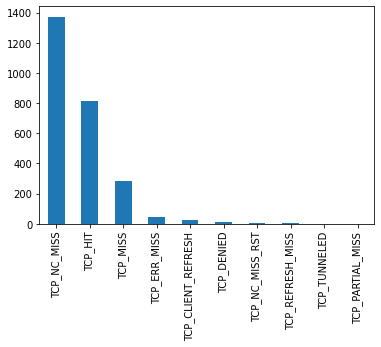

In [128]:
results_df[results_df['label']=='not benign']['cacheResult'].value_counts().plot(kind='bar')

<AxesSubplot: >

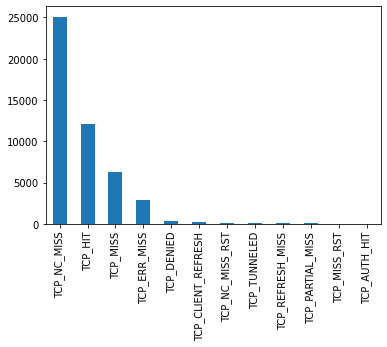

In [129]:
results_df[results_df['label']=='benign']['cacheResult'].value_counts().plot(kind='bar')

On Observing the Distribution of cache result on benign and not benign doesnt infer anything that validates the inconsitencies in user agent string formating which highly likely to cause the anomalyies

# Prediction on exploit data

In [26]:
file_name = './Downloads/sanitized_bluecoat_from_syrian_dump.webgateway/2014-01-02-neutrino-exploit-traffic.webgateway'
CHUNK_SIZE = 100000000
results_exploit = read_lines_from_file_as_data_chunks(file_name, chunk_size=CHUNK_SIZE, callback=generic_line_parser)

In [27]:
results_exploit

[{'dateTime': '02/Jan/2014:14:55:49',
  'timezone': '-0800',
  'userName': 'Nico Rosberg',
  'sourceIP': '198.61.173.192',
  'destinationIP': '151.248.0.195',
  'unknownValue': '1500',
  'statusCode': '200',
  'cacheResult': 'TCP_HIT',
  'httpMethod': 'GET',
  'urlRequested': 'http://686dkfe4k74v8nu1adebdm7.mychicagohardwoodflooring.com/index.php?f=b3hjd2NoPXhoYmomdGltZT0xNDAxMDIyMDQzMTQ1OTkxNzgyMSZzcmM9MzYwJnN1cmw9aGVscC53dWduZXQuY29tJnNwb3J0PTgwJmtleT00Qzc4Q0JCNiZzdXJpPS9vZmZpY2UvZGVsZXRlLWVtYWlsLWFkZHJlc3MtaGlzdG9yeS1PdXRsb29rLWZ0b3BpY3Q5Nzc4NTkuaHRtbA==',
  'httpVersion': '1.1',
  'domainClassification': 'Internet Services',
  'riskClassification': 'low risk ',
  'mimeType': 'text/html',
  'bytesSent': '788',
  'bytesReceived': '885',
  'userAgentString': 'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
  'webReferrerString': 'http://www.google.com/url?sa=t&rct=j&q=&esrc=s&frm=1&source=web&cd=1&ved=0CDcQFjAA&url=http%3A%2F%2Fhelp.wugnet.com%2Foffice%2Fdelete-emai

In [28]:
exploit_df = pd.DataFrame(results_exploit)

In [29]:
import joblib
model = joblib.load('benign_model.sav')

In [30]:
predictions_exploit = model.predict(exploit_df['userAgentString'])

In [31]:
predictions_exploit

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

Zero anomaly observed in exploit data as model is only trained on 35000 datapoint y increasing the data points in training set might help model learn better to identify anomalies in exploit data